#  <font color='orange'>CUNEF</font>
# `Machine Learning`
# `Yelp Dataset`
# `04 Sentiment_Analysis_NLP`
## Authors:
### Jorge Plaza Yuste
### Álvaro Gómez Pérez

## Libraries

In [124]:
# Warnings and System
import warnings
import os
import sys
warnings.filterwarnings('ignore')
# Use the os.path.abspath function to convert the relative path to an absolute path
py_dir = os.path.abspath('../src')
# Add the full path to the 'src' directory to the system path
sys.path.append(py_dir)

# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
from collections import Counter
import re
import nltk
from nltk.util import ngrams
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud


# Modeling and Metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from Preprocessor import TextPreprocessor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

import shap

#nltk dependencies
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

True

## Functions

#### Data loading and saving

In [125]:
def load_data(files):
    """
    Load the data from parque format.
    The output is a list of pandas dataframes.
    """    
    # Dataframe list:
    data = []
    
    # Iteration for loading each file:
    for i in range(0,len(files)): 

        # Store the dataframes
        reader = pd.read_parquet(files[i])

        data.append(reader)
        
    return data

def save_models_to_parquet(models, filenames):
    """
    Save the model to parquet.
    The file path must end with '.pkl'.
    """
    for model, file in zip(models, filenames):
        joblib.dump(model, file)

def load_models_from_parquet(files):
    """
    Load the models from parquet format.
    """    
    # Models list:
    models = []
    
    # Iteration for loading each model:
    for i in files: 

        # Loading and storing the models
        reader = joblib.load(i)
        models.append(reader)
        
    return models

#### Text preprocessing

In [126]:
def contractions(text):
    """
    Contraction detector and tranformer.
    """
    text = re.sub(r"won't", "will not",text)
    text = re.sub(r"would't", "would not",text)
    text = re.sub(r"could't", "could not",text)
    text = re.sub(r"'d",  " would",text)
    text = re.sub(r"can't", "can not",text)
    text = re.sub(r"n't", " not", text)
    text= re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    return text
    
# Remove non-alpha characters
def rm_non_alfa(text):
    """
    Non-alpha detector and tranformer.
    """
    text = re.sub('[^A-Za-z]+',' ', text) 
    return text

# Remove extra spaces between words 
def blanks(text):
    """
    Blanks detector and tranformer.
    """
    text = re.sub('  +', ' ', text)
    return text

# Lemmatization
def lemmatizer(text):
    """
    Reduce the words to their lemma or base form. 
    """
    lemmatizer = nltk.WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word,pos='v') for word in text.split()]
    return text

# Stop Words
def stopwords_removal(text):
    """
    Omit words that have no meaning on their own. 
    """
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

# Agrouping all the functions for preprocessing
def preprocessing(text):
    """
    Preprocessor.
    Join the previous transformers.
    """
    #Normalize
    text = text.strip().lower()
    # Clean text
    text = contractions(text)
    text = rm_non_alfa(text)
    text = blanks(text)
    text = lemmatizer(text)
    text = stopwords_removal(text)
    return text

#### Metrics

In [127]:
def confusion_matrix_plot(ytest, ypred):
    """
    Obtain the confusion matrix of the predictions for each model
    -Confusion matrix without normalization
    -Confusion matrix with normalization
    """
    cm = confusion_matrix(ytest, ypred)
    cm_norm = confusion_matrix(ytest, ypred, normalize='true')
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, 
                square = True, cmap = plt.cm.Blues,ax=ax1)
    ax1.set_title("Confusion matrix, without normalization")
    ax1.set_xlabel('Predicted values')
    ax1.set_ylabel('Real values')
    sns.heatmap(cm_norm, annot=True, fmt=".2f", linewidths=.5, 
                square = True, cmap = plt.cm.Blues,ax=ax2)
    ax2.set_title("Normalized confusion matrix")
    ax2.set_xlabel('Predicted values')
    ax2.set_ylabel('Real values')
    plt.tight_layout()
    
def show_metrics(y_true, y_pred, y_pred_proba, modelo):
    """
    Obtain the metrics for a specific model
    -accuracy
    -precision
    -recall
    -f2
    -auc
    """    
    accuracy = round(accuracy_score(y_true, y_pred),4)
    precision = round(precision_score(y_true, y_pred),4)
    recall = round(recall_score(y_true, y_pred),4)
    f0_5 = round(fbeta_score(y_true, y_pred, beta=0.5),4)
    auc = roc_auc_score(y_true, y_pred_proba[:,1])
    
    
    print(modelo, 'metrics: \n'\
         'Accuracy: ',str(accuracy),'\n'\
         'Precision: ',str(precision),'\n'\
         'Recall: ',str(recall),'\n'\
         'F0.5: ',str(f0_5),'\n'\
         'AUC: ',str(auc))
    
def plot_precision_recall_curve(ytest, prob_predictions, modelo):
    """
    -get precision - recall curve   
    """
    # keep probabilities for the positive outcome only
    yhat = prob_predictions[:, 1]
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(ytest, yhat)
    # convert to f2 score
    f05_score = (1.25 * precision * recall) / (precision * 0.25 + recall)
    # locate the index of the largest f score
    ix = np.nanargmax(f05_score)
    print('Best Threshold=%f, F0.5-Score=%.3f' % (thresholds[ix], f05_score[ix]))
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label=modelo)
    plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
def curves(ytest, prob_predictions):
    """
    -get the Roc Curve
    -get the cumulative_gain_curve
    -get the lift curve    
    """    
    f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,3), dpi=90)
    # ROC curve:
    # keep probabilities for the positive outcome only
    yhat = prob_predictions[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(ytest, yhat)
    # plot the roc curve for the model
    ax1.plot([0,1], [0,1], linestyle='--', label='No Skill')
    ax1.plot(fpr, tpr, marker='.', label='Random Forest')
    ax1.set_title("ROC Curve")
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend()
    
    # Gain curve:
    plot_cumulative_gain(ytest, prob_predictions, ax=ax2)
    
    # Lift Curve:
    plot_lift_curve(ytest, prob_predictions, ax=ax3)

## Data loading and display

In [128]:
# List of dataset path-files 
filenames = ["../data/reviews.parquet"]

# loading the datasets
reviews = load_data(filenames)[0]

In [129]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31


## Modeling Objectives

* Generate different machine learning models that will be able to output the probability of the sentiment/experience of the users in the respective restaurants.
* Compare the different models generated, to see which one offers better results.

## NLP

### EDA

 We create a copy of the dataset so as not to contaminate the data during the descriptive analysis.

In [130]:
reviews_subset = reviews.copy()

Since this dataset is so large, we will work with a random sample of 100,000 reviews

In [131]:
reviews_subset = reviews_subset.sample(n=100000, weights=reviews_subset["stars"], random_state=42).reset_index(drop=True)

In [132]:
reviews_subset.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,oC18N3RGykRnd1pUWIbjtw,CmR9s-2zH20UkmUt5Qwqnw,bq0n3CQy1CkE_WUe76zQvg,4.0,2,0,1,Third re-review. Was here about 3 days ago...O...,2020-01-11 03:53:12
1,kEP0T0OfL-Nz-gtK4Ym0Ig,gxsAcXr7xUIF1_TlKQKjhw,FMCSWZhN48YXiASbWFdSEQ,5.0,0,0,0,This restaurant/pub/bar is one of my favorites...,2019-06-01 21:15:30
2,u7vok-sLRv02wdk5_2UCvQ,4vKCsUbWLvT3U1pWE_twMw,aLL1V6Vr02dLFtSJsp5Ksw,5.0,0,0,0,We have been to countless chipotles across the...,2016-10-25 01:56:43
3,p78QryTt6pTI6c9fW_RsaQ,c9P7Ny6z7e_r8n_GkBc4wg,hxh1ongobphqXq30V13ukg,4.0,0,0,0,Went here around 7 on a Saturday night for din...,2016-02-24 15:24:47
4,0j0Pn2AkbxwuGMWFb4355g,647tuHTcRtokSdCSElNV0w,L4G5ABxhYHQAKIcT0818_A,5.0,1,0,0,"Great, no frills, classic diner. Small inside....",2017-11-07 23:46:33


#### Preprocessing

In the preprocessing of the text variable, we have eliminated contractions (won't), spaces and alphanumeric characters. In addition, stopwords have been eliminated too and a lemmatization process has been performed. Stopwords are typically function words that do not contribute much meaning to a sentence, and are often used to provide structure rather than content. For example, in the sentence "The cat sat on the mat," the words "the" and "on" are stopwords. Lemmatization is a process in natural language processing (NLP) that involves determining the lemma, or base form, of a word. A lemma is the base form of a word that can be inflected (such as "run," "running," and "ran"), whereas the inflected form of a word is known as its inflection.
For example, the lemma of the word "was" is "be," the lemma of the word "better" is "good," and the lemma of the word "running" is "run." You can see all this process in the Preprocessor.py

Now, you can see a comparative between a clean text and normal text of the data.

In [133]:
reviews_subset['clean_text'] = reviews_subset['text'].map(lambda x: preprocessing(x))

In [134]:
reviews_subset['clean_text'].tolist()[1]

'restaurant pub bar one favorites never bad meal service stupendous literally run make sure service good could go every night'

In [136]:
reviews_subset['text'].tolist()[1]

'This restaurant/pub/bar is one of my favorites.  I have NEVER had a bad meal there and the service is stupendous.  They literally RUN to make sure the service is good. I could go there every night.'

#### Recoding target

We create a sentiment variable that takes the value of 1 if the reviews are 4 or 5 stars and the value of 0 if the reviews are 1,2 or 3 stars.

In [13]:
# Recode 1,2, and 3 stars as 0 (negative review)
# Recode 4 and 5 stars as 1 (positive review)

reviews_subset['sentiment']=reviews_subset['stars'].replace({'1.0':0,'2.0':0,'3.0':0,'4.0':1,'5.0':1})
reviews_subset.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_text,sentiment
0,oC18N3RGykRnd1pUWIbjtw,CmR9s-2zH20UkmUt5Qwqnw,bq0n3CQy1CkE_WUe76zQvg,4.0,2,0,1,Third re-review. Was here about 3 days ago...O...,2020-01-11 03:53:12,third review days ago order follow items sever...,1
1,kEP0T0OfL-Nz-gtK4Ym0Ig,gxsAcXr7xUIF1_TlKQKjhw,FMCSWZhN48YXiASbWFdSEQ,5.0,0,0,0,This restaurant/pub/bar is one of my favorites...,2019-06-01 21:15:30,restaurant pub bar one favorites never bad mea...,1
2,u7vok-sLRv02wdk5_2UCvQ,4vKCsUbWLvT3U1pWE_twMw,aLL1V6Vr02dLFtSJsp5Ksw,5.0,0,0,0,We have been to countless chipotles across the...,2016-10-25 01:56:43,countless chipotles across us one best service...,1
3,p78QryTt6pTI6c9fW_RsaQ,c9P7Ny6z7e_r8n_GkBc4wg,hxh1ongobphqXq30V13ukg,4.0,0,0,0,Went here around 7 on a Saturday night for din...,2016-02-24 15:24:47,go around saturday night dinner bf lucked coup...,1
4,0j0Pn2AkbxwuGMWFb4355g,647tuHTcRtokSdCSElNV0w,L4G5ABxhYHQAKIcT0818_A,5.0,1,0,0,"Great, no frills, classic diner. Small inside....",2017-11-07 23:46:33,great frills classic diner small inside cash o...,1


In [14]:
reviews_subset.sentiment.unique()

array([1, 0], dtype=int64)

In [15]:
# getting the percetage for the stars column classes:
reviews_subset['sentiment'] = reviews_subset['sentiment'].astype('float32')
fraude_percentage = reviews_subset['sentiment']\
        .value_counts(normalize=True)\
        .mul(100).rename('Percentage').reset_index()
fraude_percentage_count = reviews_subset['sentiment'].value_counts().reset_index()
fraude_percentage_distribution = pd.merge(fraude_percentage, fraude_percentage_count, on=['index'], how='inner')
fraude_percentage_distribution.set_index('index').sort_index()

,Percentage,sentiment
index,,
0.0,16.811,16811
1.0,83.189,83189


The dataset is unbalanced. There are many more good experiences than bad ones.

#### Term Frequency Analysis

Exploring frequency of words in the news

In [16]:
# Separating the total reviews into positive reviews and negative reviews
pos_reviews = reviews_subset.clean_text[reviews_subset.sentiment == 1]
neg_reviews = reviews_subset.clean_text[reviews_subset.sentiment == 0]

In [17]:
pos_reviews.head()

0    third review days ago order follow items sever...
1    restaurant pub bar one favorites never bad mea...
2    countless chipotles across us one best service...
3    go around saturday night dinner bf lucked coup...
4    great frills classic diner small inside cash o...
Name: clean_text, dtype: object

In [18]:
neg_reviews.head()

9     fair think would give star option location gre...
10    long line food check lunchtime sunday cashier ...
14    family move seminole heights want great burger...
21    love international flavor excite try place fla...
26    usually fly lambert airport super early mornin...
Name: clean_text, dtype: object

In [19]:
# We join all the positive reviews from the text column separated by a blank space
text_pos_reviews = ' '.join(pos_reviews)
# # We join all the negative reviews from the text column separated by a blank space
text_neg_reviews = ' '.join(neg_reviews)
# We join all the reviews from the text column separated by a blank space
all_text = ' '.join(reviews_subset.clean_text)

### Plots

Let's plot the 30 most frequent words of all reviews, positive reviews and negative reviews to make a comparison.

Text(0.5, 1.0, 'Top 30 words in Positive Reviews')

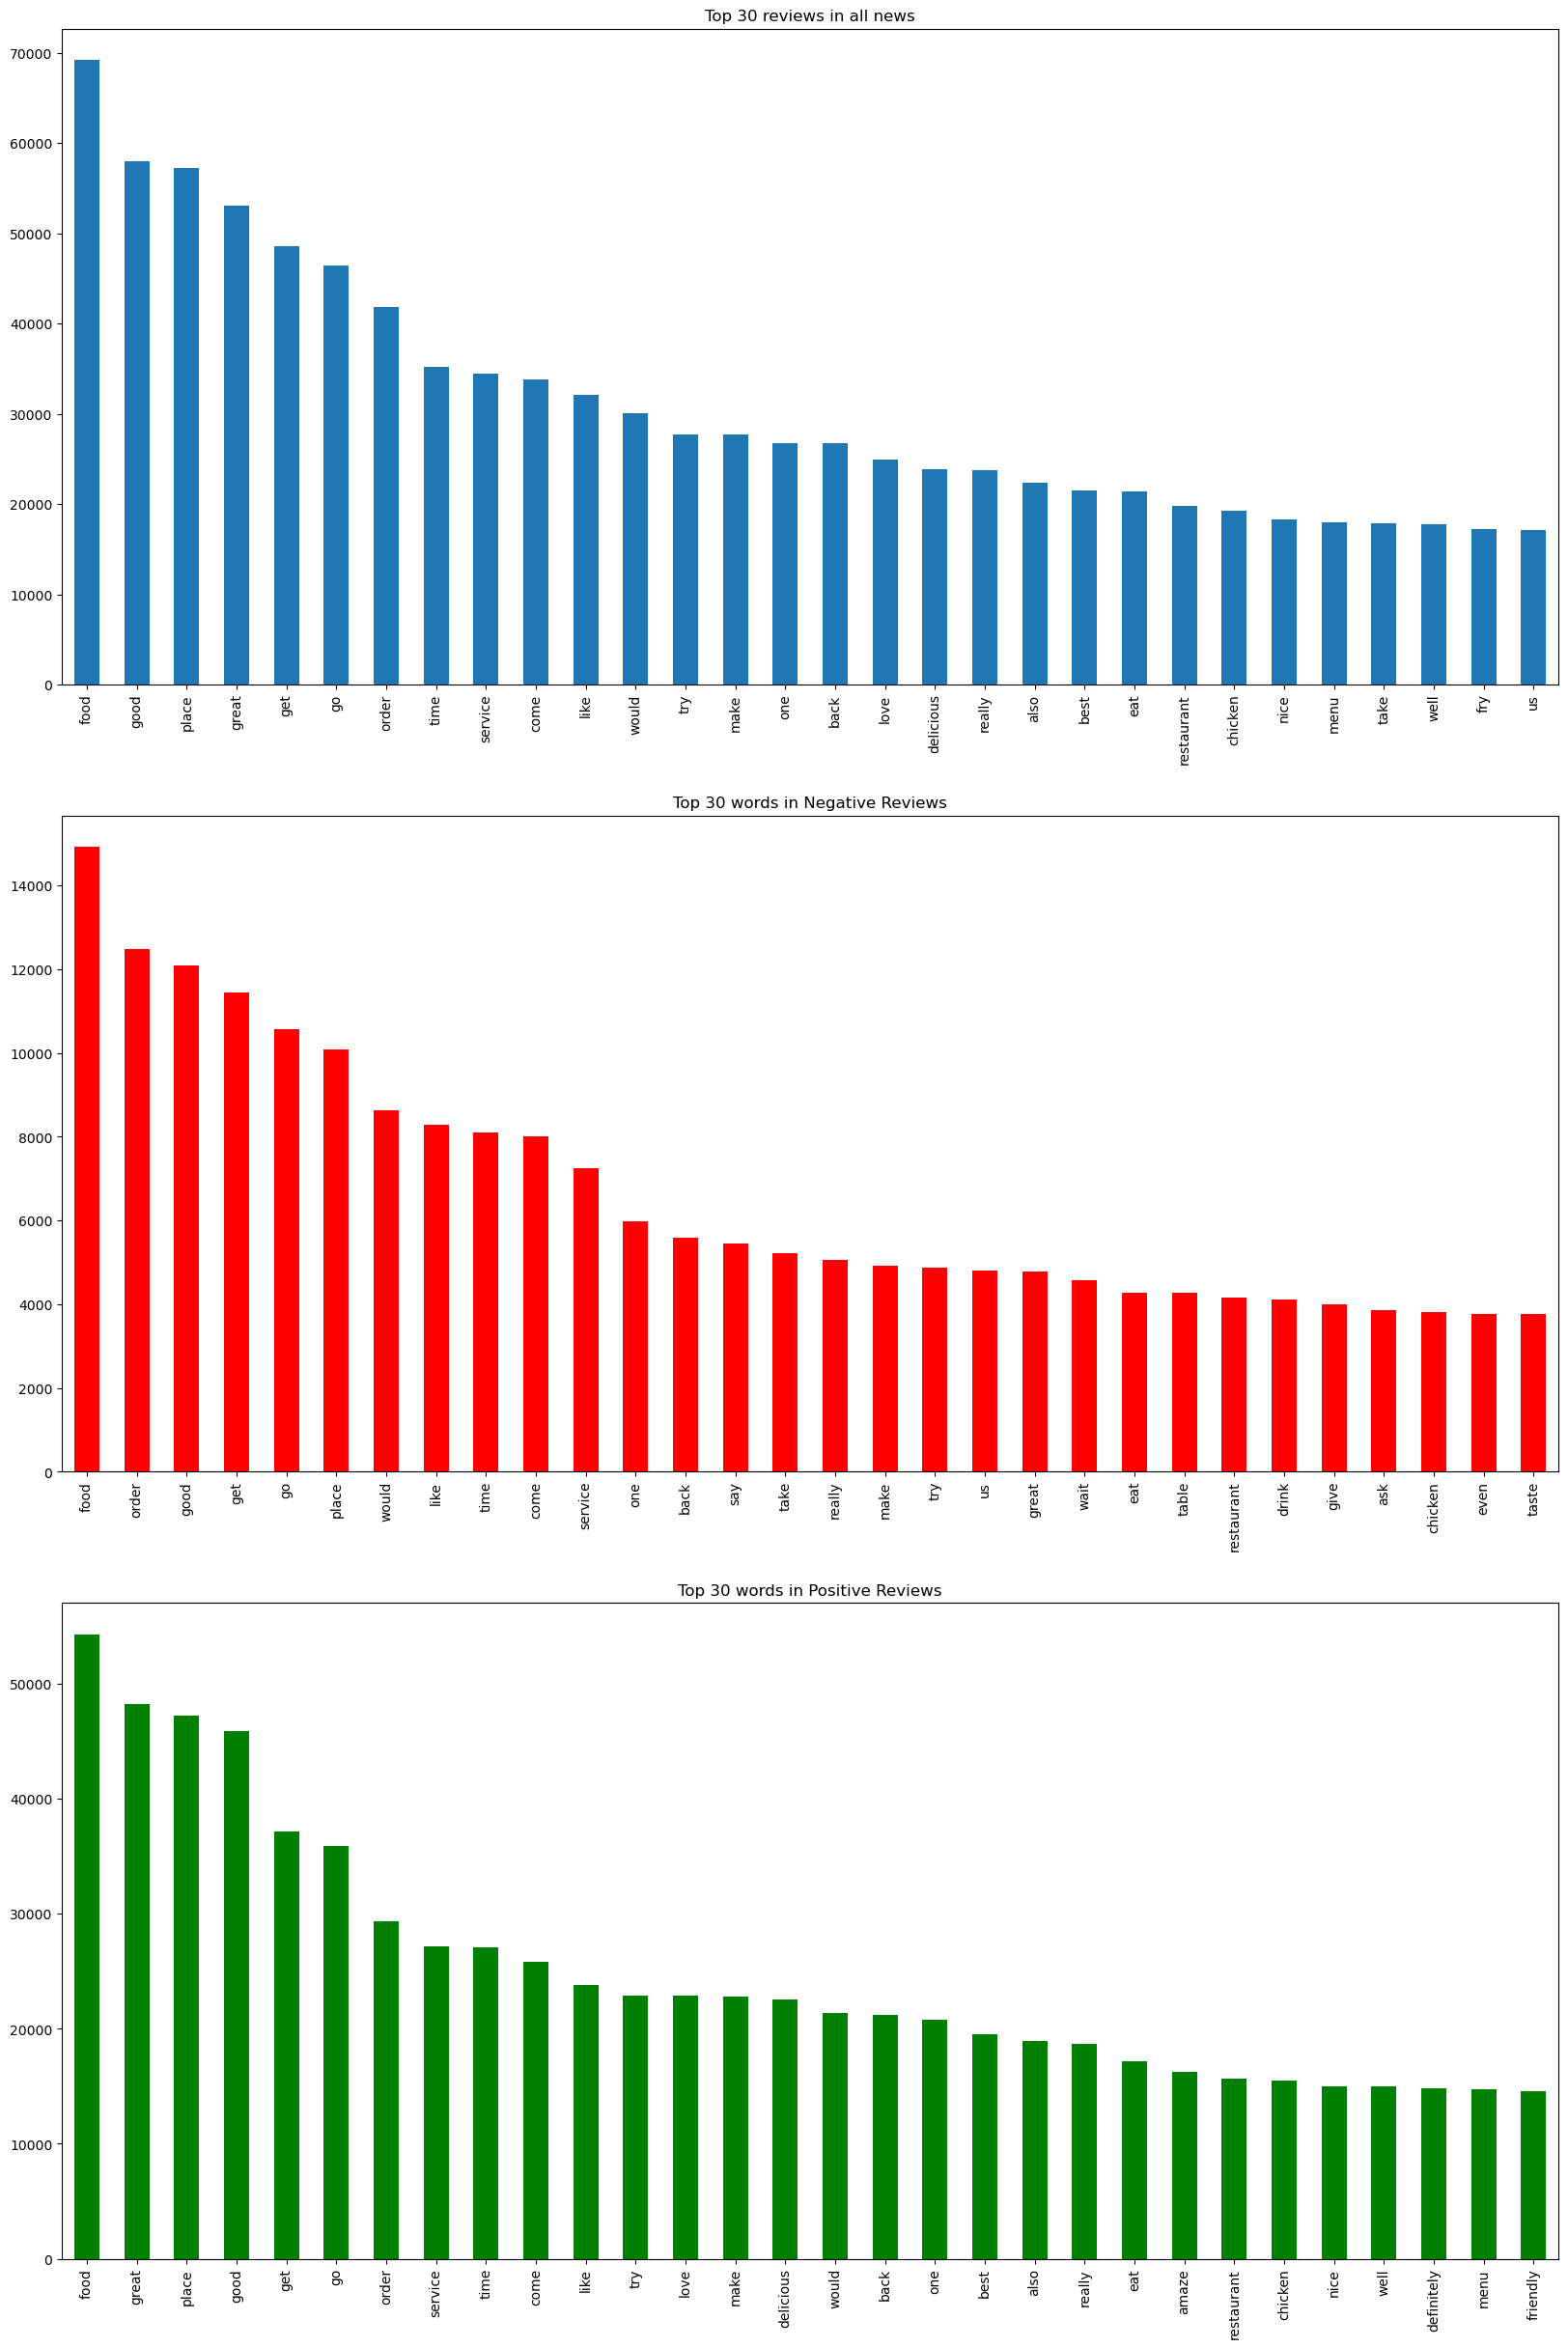

In [20]:
fig, axs = plt.subplots(3,1, figsize=(20,30))

# We use the word_tokenize function from the nltk library to split the text into individual words (tokens)
pd.Series(Counter(word_tokenize(all_text))).sort_values(ascending=False).iloc[:30].plot(kind="bar", ax=axs[0]).set_title('Top 30 reviews in all news')
pd.Series(Counter(word_tokenize(text_neg_reviews))).sort_values(ascending=False).iloc[:30].plot(kind="bar", color="red",ax=axs[1]).set_title('Top 30 words in Negative Reviews')
pd.Series(Counter(word_tokenize(text_pos_reviews))).sort_values(ascending=False).iloc[:30].plot(kind="bar", color="green",ax=axs[2]).set_title('Top 30 words in Positive Reviews')

We can see how words such as "food", "place", "service", "order" related to the world of hospitality are the most common in all reviews, both positive and negative. In addition, we see how the word "good" is very present in both categories, so we deduce that it does not help us to classify. As expected, positive adjectives such as "delicious", "great" are the most common words in the good experience reviews. In addition, it can be observed that the word "time" is the most common word in the positive reviews and the word "wait" is the most common word in the negative reviews.

#### Word Cloud

A wordcloud is a visualization of keywords that is often used in text analysis to represent the importance of words or phrases in a document or set of documents. The most frequent words are shown with a larger size, allowing you to quickly identify the most relevant words in the text.

For example, if a set of product reviews is analyzed, a wordcloud might show the words "delicious", "excellent", and "recommended" with a larger size, since they are likely mentioned more frequently in positive reviews.

In [21]:
# The function creates a word cloud using the WordCloud class from the wordcloud library
def wordcloud_plot(texto, color_fondo, color_palabras):
    wordcloud = WordCloud(width=3000, 
                          height=2000, 
                          random_state=2022, 
                          background_color=color_fondo, 
                          colormap=color_palabras,
                          collocations=False).generate(texto) 
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud) 
    plt.axis("off");
    return wordcloud



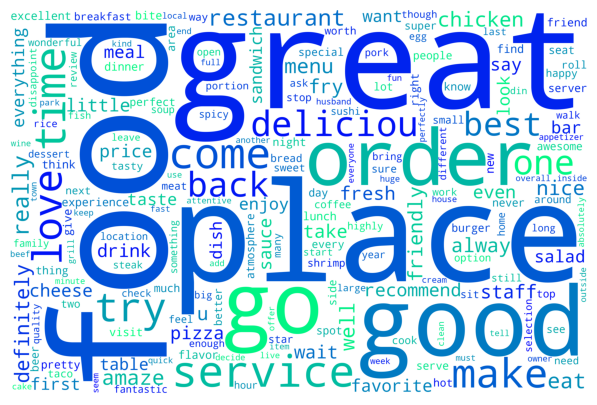

In [22]:
# Positive reviews wordcloud
wordcloud_plot(text_pos_reviews, 'white', 'winter_r')

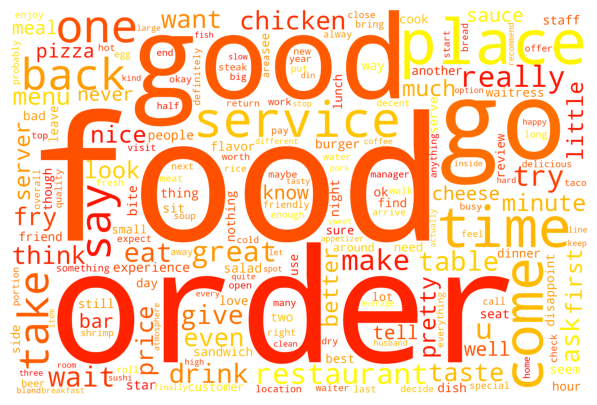

In [23]:
# Negative reviews wordcloud
wordcloud_plot(text_neg_reviews, 'white', 'autumn_r')

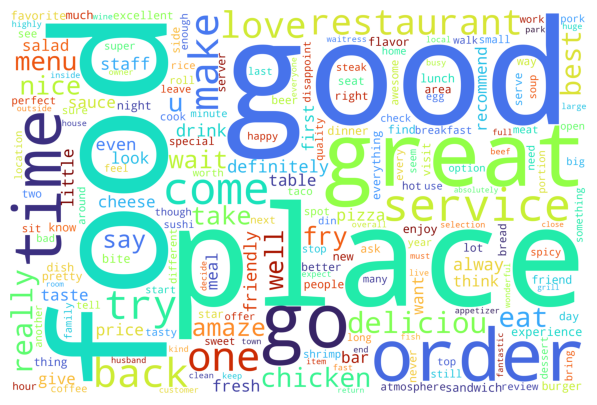

In [24]:
# All reviews wordcloud
wordcloud_plot(all_text, 'white', 'turbo_r')

Therefore, through these wordclouds we visualize the same information of the previous bar charts using the size of the words to analyze if the word is common or not in the reviews

## Dataset split

In [25]:
reviews_subset = reviews.copy()
reviews_subset = reviews_subset.sample(n=500000, random_state=666).reset_index(drop=True)
reviews_subset['sentiment']=reviews_subset['stars'].replace({'1.0':0,'2.0':0,'3.0':0,'4.0':1,'5.0':1})

In [26]:
# Splitting predictor data and target data:
X = reviews_subset.drop(['stars','sentiment'], axis = 1)
Y = reviews_subset.sentiment
# As we are with unbalanced data, stratify=Y
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=1234)

## Preprocessor

In [27]:
# Grouping all the individual pipelines:
preprocessor = Pipeline(steps=[
    ('data_preprocessor', TextPreprocessor())
    ])

In [28]:
xtrain_preprocessed = preprocessor.fit_transform(X=xtrain)

In [29]:
xtrain_preprocessed

170501    come around fairly busy come baby nice high ch...
343883    food good buffalo chicken egg roll favorite re...
323901    definitely love seafood market poboys order ph...
389540    cute little place friend go tonight first time...
12854     multiple occasion dinner great experience grea...
                                ...                        
479672    chicago bake oyster absolute best thing menu d...
396765    disservice eat days paris city market work res...
324271    write separate review place nd visit try parta...
295530    best tacos santa b rbara tacos greasy tortilla...
486612    go quick dinner bar boyfriend say need minute ...
Name: text, Length: 350000, dtype: object

In [30]:
xtest_preprocessed = preprocessor.fit_transform(X=xtest)

## Model Selection

### Dummy model

#### Setting the model

In [31]:
base_model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("clf", DummyClassifier(strategy="most_frequent"))
])

#### Fitting the model

In [32]:
# Fitting the Dummy base model
base_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('clf', DummyClassifier(strategy='most_frequent'))])

#### Predictions

In [33]:
# Predictions and metrics:
y_pred_dummy = base_model.predict(xtest_preprocessed)
y_pred_dummy_prob = base_model.predict_proba(xtest_preprocessed)

#### Metrics

In [34]:
# Metrics display:
show_metrics(ytest, y_pred_dummy, y_pred_dummy_prob, 'Dummy')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_dummy))

Dummy metrics: 
Accuracy:  0.6792 
Precision:  0.6792 
Recall:  1.0 
F0.5:  0.7258 
AUC:  0.5

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     48117
           1       0.68      1.00      0.81    101883

    accuracy                           0.68    150000
   macro avg       0.34      0.50      0.40    150000
weighted avg       0.46      0.68      0.55    150000



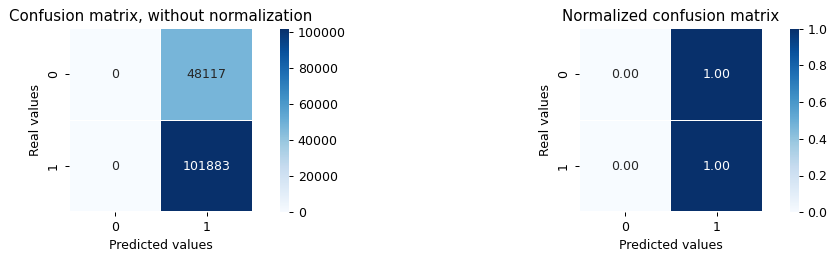

In [35]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_dummy)

### Logistic Regression

#### Setting the model

In [36]:
LR_model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("clf", LogisticRegression())
])

#### Fitting the model

In [37]:
# Fitting the Logistic Regression model
LR_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('clf', LogisticRegression())])

#### Predictions

In [38]:
# Calculating the probs for each class:
y_pred_log_prob = LR_model.predict_proba(xtest_preprocessed)

Best Threshold=0.722240, F0.5-Score=0.937


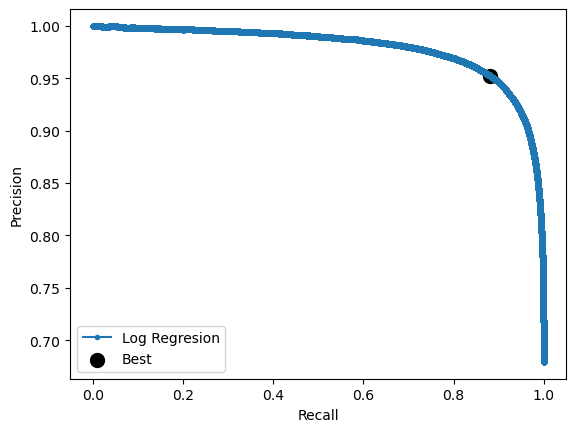

In [39]:
# Plotting Precision-recall relation to maximize F0.5 Score:
plot_precision_recall_curve(ytest, y_pred_log_prob, 'Log Regresion')

In [40]:
# Set the proba threshold to get the predictions:
threshold = 0.72
y_pred_log = (y_pred_log_prob[:,1] >= threshold).astype('int')

#### Metrics

In [41]:
# Metrics display:
show_metrics(ytest, y_pred_log, y_pred_log_prob, 'Log Regresion')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_log))

Log Regresion metrics: 
Accuracy:  0.89 
Precision:  0.9519 
Recall:  0.8827 
F0.5:  0.9372 
AUC:  0.9599823498186748

Classification Report

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     48117
           1       0.95      0.88      0.92    101883

    accuracy                           0.89    150000
   macro avg       0.87      0.89      0.88    150000
weighted avg       0.90      0.89      0.89    150000



In [42]:
# Train metrics display:
y_pred_log_train = LR_model.predict(xtrain_preprocessed)
y_pred_log_prob_train = LR_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_log_train, y_pred_log_prob_train, 'Log Regresion')

Log Regresion metrics: 
Accuracy:  0.9165 
Precision:  0.9255 
Recall:  0.9539 
F0.5:  0.931 
AUC:  0.9666195052406164


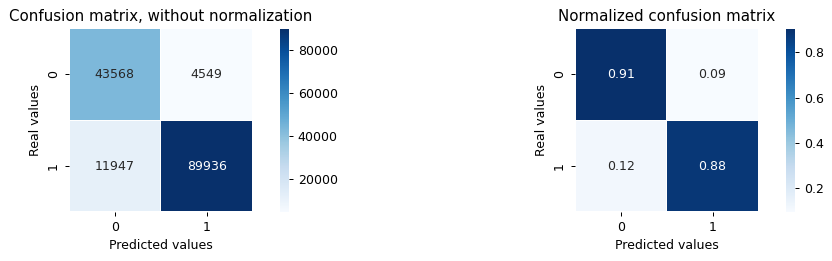

In [43]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_log)

### Naive Bayes

#### Setting the model

In [44]:
NB_model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("clf",  MultinomialNB())
])

#### Fitting the model

In [45]:
# Fitting the Naive Bayes model
NB_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', MultinomialNB())])

#### Predictions

In [46]:
# Calculating the probs for each class:
y_pred_nb_prob = NB_model.predict_proba(xtest_preprocessed)

Best Threshold=0.762859, F0.5-Score=0.915


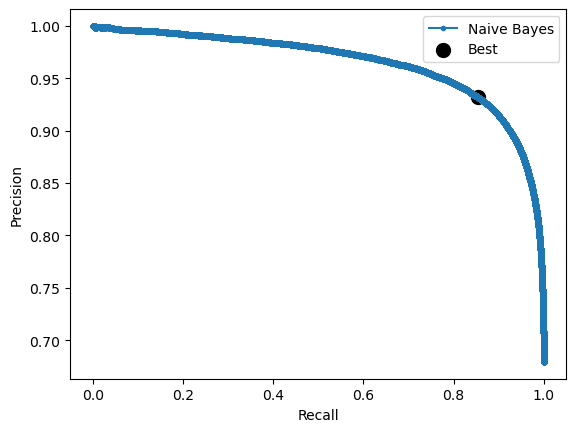

In [47]:
# Plotting Precision-recall relation to maximize F0.5 Score:
plot_precision_recall_curve(ytest, y_pred_nb_prob, 'Naive Bayes')

In [48]:
# Set the proba threshold to get the predictions:
threshold = 0.76
y_pred_nb = (y_pred_nb_prob[:,1] >= threshold).astype('int')

#### Metrics

In [49]:
# Metrics display:
show_metrics(ytest, y_pred_nb, y_pred_nb_prob, 'Naive Bayes')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_nb))

Naive Bayes metrics: 
Accuracy:  0.8598 
Precision:  0.9309 
Recall:  0.8572 
F0.5:  0.9152 
AUC:  0.9354736934036896

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.87      0.80     48117
           1       0.93      0.86      0.89    101883

    accuracy                           0.86    150000
   macro avg       0.84      0.86      0.85    150000
weighted avg       0.87      0.86      0.86    150000



In [50]:
# Train metrics display:
y_pred_nb_train = NB_model.predict(xtrain_preprocessed)
y_pred_nb_prob_train = NB_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_nb_train, y_pred_nb_prob_train, 'Naive Bayes')

Naive Bayes metrics: 
Accuracy:  0.8674 
Precision:  0.85 
Recall:  0.9773 
F0.5:  0.8727 
AUC:  0.9436059654897392


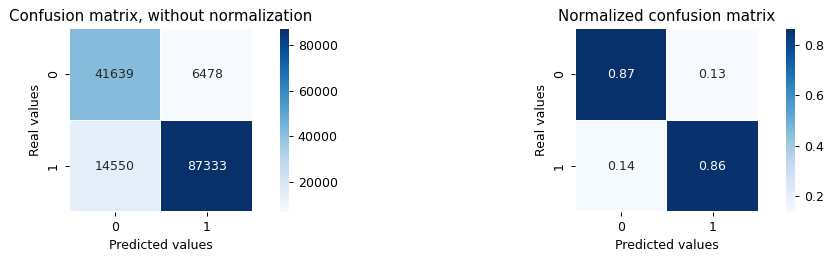

In [51]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_nb)

### Random Forest

#### Setting the model

In [52]:
RF_model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("clf",  RandomForestClassifier(n_jobs=-1))
])

#### Fitting the model

In [53]:
# Fitting the Random Forest model
RF_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier(n_jobs=-1))])

#### Predictions

In [54]:
# Calculating the probs for each class:
y_pred_rf_prob = RF_model.predict_proba(xtest_preprocessed)

Best Threshold=0.669882, F0.5-Score=0.923


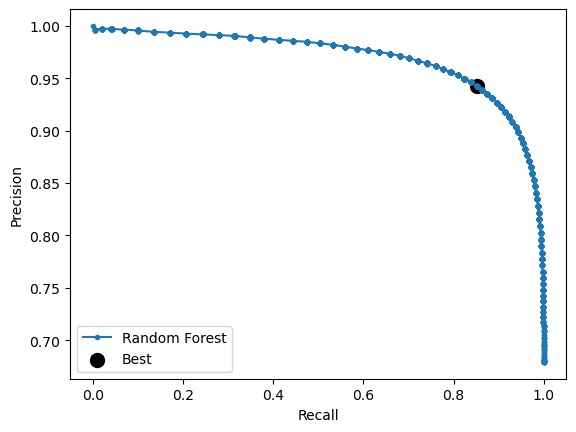

In [55]:
# Plotting Precision-recall relation to maximize F0.5 Score:
plot_precision_recall_curve(ytest, y_pred_rf_prob, 'Random Forest')

In [56]:
# Set the proba threshold to get the predictions:
threshold = 0.66
y_pred_rf = (y_pred_rf_prob[:,1] >= threshold).astype('int')

#### Metrics

In [57]:
# Metrics display:
show_metrics(ytest, y_pred_rf, y_pred_rf_prob, 'Random Forest')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_rf))

Random Forest metrics: 
Accuracy:  0.8694 
Precision:  0.9392 
Recall:  0.8635 
F0.5:  0.923 
AUC:  0.945061573004418

Classification Report

              precision    recall  f1-score   support

           0       0.75      0.88      0.81     48117
           1       0.94      0.86      0.90    101883

    accuracy                           0.87    150000
   macro avg       0.85      0.87      0.86    150000
weighted avg       0.88      0.87      0.87    150000



In [58]:
# Train metrics display:
y_pred_rf_train = RF_model.predict(xtrain_preprocessed)
y_pred_rf_prob_train = RF_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_rf_train, y_pred_rf_prob_train, 'Random Forest')

Random Forest metrics: 
Accuracy:  1.0 
Precision:  1.0 
Recall:  1.0 
F0.5:  1.0 
AUC:  0.999999927239206


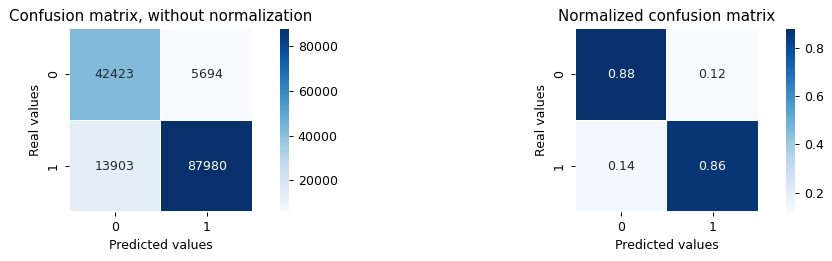

In [59]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_rf)

### XGBoost

#### Setting the model

In [60]:
XGB_model = Pipeline([
        ("vectorizer", TfidfVectorizer()),
        ("clf", XGBClassifier())
])

#### Fitting the model

In [61]:
# Fitting the XGBoost model
XGB_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

#### Predictions

In [62]:
# Calculating the probs for each class:
y_pred_xgb_prob = XGB_model.predict_proba(xtest_preprocessed)

Best Threshold=0.704805, F0.5-Score=0.923


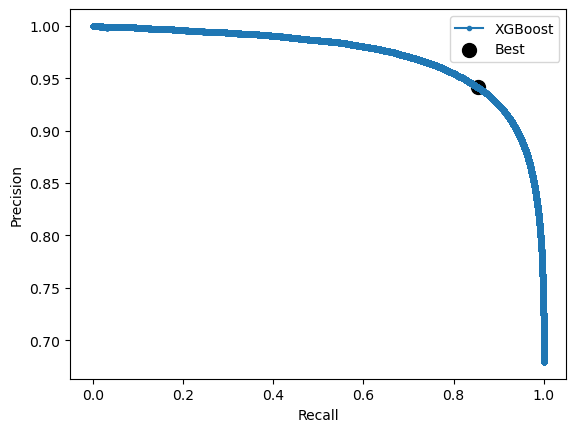

In [63]:
# Plotting Precision-recall relation to maximize F0.5 Score:
plot_precision_recall_curve(ytest, y_pred_xgb_prob, 'XGBoost')

In [64]:
# Set the proba threshold to get the predictions:
threshold = 0.70
y_pred_xgb = (y_pred_xgb_prob[:,1] >= threshold).astype('int')

#### Metrics

In [65]:
# Metrics display:
show_metrics(ytest, y_pred_xgb, y_pred_xgb_prob, 'XGBoost')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_xgb))

XGBoost metrics: 
Accuracy:  0.8657 
Precision:  0.9406 
Recall:  0.8563 
F0.5:  0.9225 
AUC:  0.9462103292102219

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.89      0.81     48117
           1       0.94      0.86      0.90    101883

    accuracy                           0.87    150000
   macro avg       0.84      0.87      0.85    150000
weighted avg       0.88      0.87      0.87    150000



In [66]:
# Train metrics display:
y_pred_xgb_train = XGB_model.predict(xtrain_preprocessed)
y_pred_xgb_prob_train = XGB_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_xgb_train, y_pred_xgb_prob_train, 'XGBoost')

XGBoost metrics: 
Accuracy:  0.9028 
Precision:  0.9077 
Recall:  0.9538 
F0.5:  0.9166 
AUC:  0.958073417839419


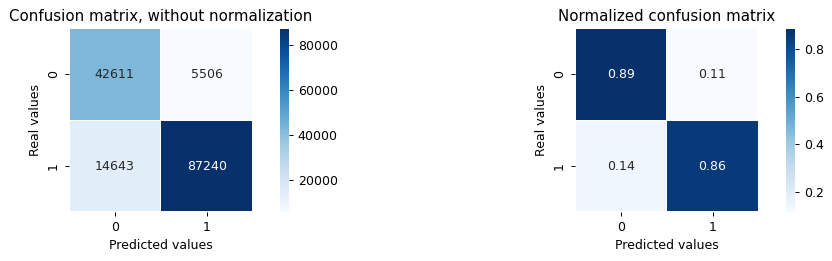

In [67]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_xgb)

### LGBM

#### Setting the model

In [68]:
LGBM_model= Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("clf", LGBMClassifier ())
])

#### Fitting the model

In [69]:
# Fitting the LGBM model
LGBM_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', LGBMClassifier())])

#### Predictions

In [70]:
# Calculating the probs for each class:
y_pred_lgbm_prob = LGBM_model.predict_proba(xtest_preprocessed)

Best Threshold=0.723424, F0.5-Score=0.922


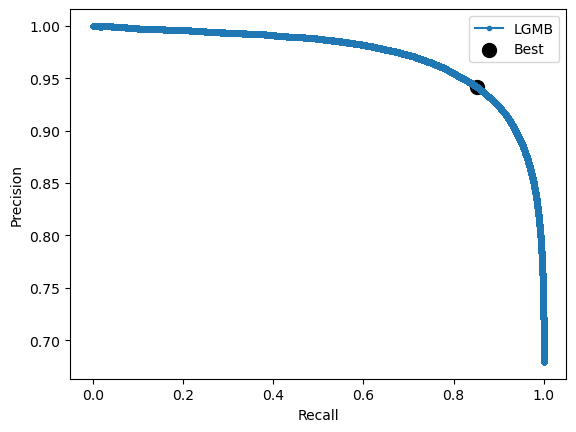

In [71]:
# Plotting Precision-recall relation to maximize F0.5 Score:
plot_precision_recall_curve(ytest, y_pred_lgbm_prob, 'LGMB')

In [72]:
# Set the proba threshold to get the predictions:
threshold = 0.72
y_pred_lgbm = (y_pred_lgbm_prob[:,1] >= threshold).astype('int')

#### Metrics

In [73]:
# Metrics display:
show_metrics(ytest, y_pred_lgbm, y_pred_lgbm_prob, 'LGBM')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_lgbm))

LGBM metrics: 
Accuracy:  0.8648 
Precision:  0.9407 
Recall:  0.8549 
F0.5:  0.9222 
AUC:  0.9462860446241279

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.89      0.81     48117
           1       0.94      0.85      0.90    101883

    accuracy                           0.86    150000
   macro avg       0.84      0.87      0.85    150000
weighted avg       0.88      0.86      0.87    150000



In [74]:
# Train metrics display:
y_pred_lgbm_train = LGBM_model.predict(xtrain_preprocessed)
y_pred_lgbm_prob_train = LGBM_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_lgbm_train, y_pred_lgbm_prob_train, 'LGBM')

LGBM metrics: 
Accuracy:  0.8918 
Precision:  0.9009 
Recall:  0.9445 
F0.5:  0.9093 
AUC:  0.9509689147598118


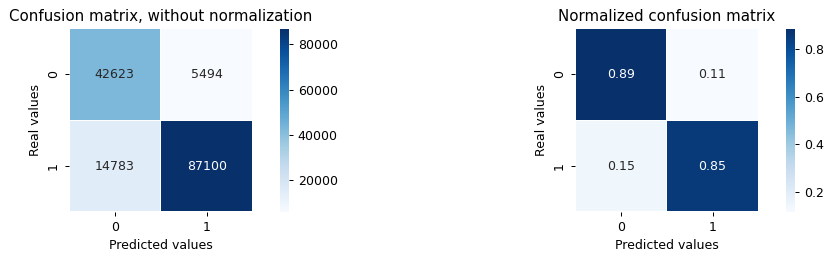

In [75]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_lgbm)

### SGD

#### Setting the model 

In [76]:
SGD_model= Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("clf", SGDClassifier(loss = 'log_loss'))
])

#### Fitting the model

In [77]:
# Fitting the SGD model
SGD_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('clf', SGDClassifier(loss='log_loss'))])

#### Predictions

In [78]:
# Calculating the probs for each class:
y_pred_sgd_prob = SGD_model.predict_proba(xtest_preprocessed)

Best Threshold=0.678485, F0.5-Score=0.928


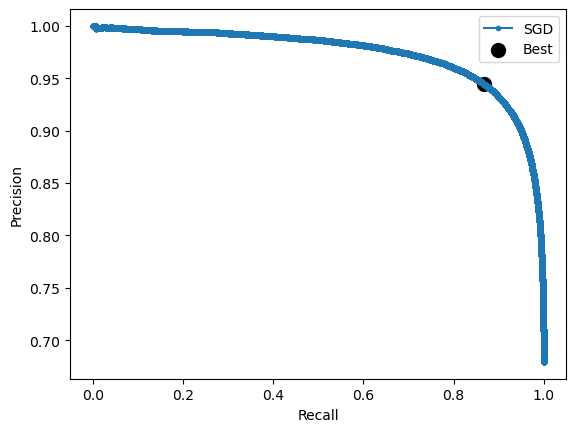

In [79]:
# Plotting Precision-recall relation to maximize F2 Score:
plot_precision_recall_curve(ytest, y_pred_sgd_prob, 'SGD')

In [80]:
# Set the proba threshold to get the predictions:
threshold = 0.67
y_pred_sgd = (y_pred_sgd_prob[:,1] >= threshold).astype('int')

#### Metrics

In [81]:
# Metrics dispaly:
show_metrics(ytest, y_pred_sgd, y_pred_sgd_prob, 'SGD')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_sgd))

SGD metrics: 
Accuracy:  0.8783 
Precision:  0.9425 
Recall:  0.8741 
F0.5:  0.928 
AUC:  0.9499986266764417

Classification Report

              precision    recall  f1-score   support

           0       0.77      0.89      0.82     48117
           1       0.94      0.87      0.91    101883

    accuracy                           0.88    150000
   macro avg       0.86      0.88      0.87    150000
weighted avg       0.89      0.88      0.88    150000



In [82]:
# Train metrics display:
y_pred_sgd_train = SGD_model.predict(xtrain_preprocessed)
y_pred_sgd_prob_train = SGD_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_sgd_train, y_pred_sgd_prob_train, 'SGD')

SGD metrics: 
Accuracy:  0.8927 
Precision:  0.8902 
Recall:  0.9605 
F0.5:  0.9034 
AUC:  0.9519730238332601


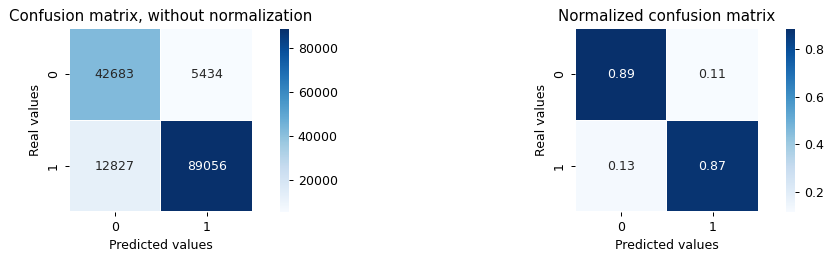

In [83]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_sgd)

#### Pickle

We are going to save the models in a pickle format.

In [84]:
# models = [
#     base_model,
#     LR_model,
#     RF_model,
#     XGB_model,
#     LGBM_model,
#     SGD_model
# ]

# filenames = [
#     '../models/reviews/base_model.pkl',
#     '../models/reviews/LR_model.pkl',
#     '../models/reviews/NB_model.pkl',
#     '../models/reviews/RF_model',
#     '../models/reviews/XGB_model',
#     '../models/reviews/LGBM_model',
#     '../models/reviews/SGD_model'
# ]

# save_models_to_parquet(models,filenames)

Loading the models from a pickle format.

In [85]:
# filenames = [
#     '../models/reviews/base_model.pkl',
#     '../models/reviews/LR_model.pkl',
#     '../models/reviews/NB_model.pkl',
#     '../models/reviews/RF_model',
#     '../models/reviews/XGB_model',
#     '../models/reviews/LGBM_model',
#     '../models/reviews/SGD_model'
# ]

# base_model, LR_model, RF_model, XGB_model, LGBM_model, SGD_model = load_models_from_parquet(filenames)

We have chosen the Logistic Regresion as the best model. The metric chosen when we were making the selection was precision = TP / (TP + FP). We have considered looking for a high Precision metric trying to minimize false positives as much as possible. In this line of business, The biggest cost will be that the review was rated as good (class 1) when the user actually had a bad experience at that restaurant. Therefore, we have considered that Logistic Regresion is the best model since it minimizes false positives the most among those with the highest precision, as can be seen in its confusion matrix.Therefore, the model has a precision of 0.9 with a FP rate of 0.18.

### Tunning Logistic Regression

In [86]:
seed = 6666

# Setting the model:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("clf", LogisticRegression(random_state=seed))
])

In [87]:
param_grid = {'clf__C': [0.1, 1, 10],
              'clf__penalty': ['l2'],
              'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'clf__max_iter': [100, 500]}

#### Fitting the model

In [88]:
# Use cross-validation to find the optimal hyperparameters
log_reg_cv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=8)

# Fitting the model
log_reg_cv.fit(xtrain_preprocessed, ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=6666))]),
             n_jobs=8,
             param_grid={'clf__C': [0.1, 1, 10], 'clf__max_iter': [100, 500],
                         'clf__penalty': ['l2'],
                         'clf__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                         'sag', 'saga']})

In [89]:
log_reg_cv.best_params_

{'clf__C': 1,
 'clf__max_iter': 100,
 'clf__penalty': 'l2',
 'clf__solver': 'lbfgs'}

#### Predict

In [90]:
# Calculating the probs for each class:
y_pred_logreg_prob = log_reg_cv.predict_proba(xtest_preprocessed)

Best Threshold=0.722240, F0.5-Score=0.937


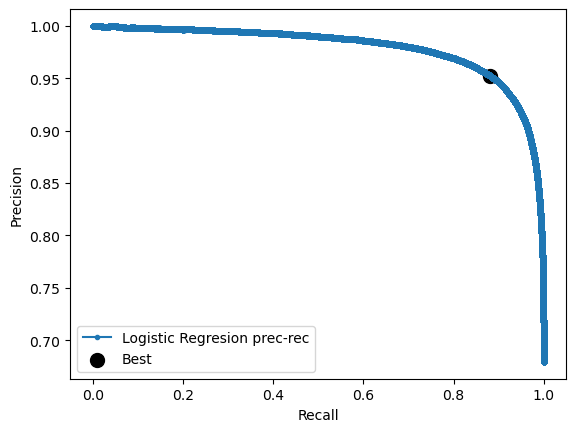

In [91]:
# Plotting Precision-recall relation to  F2 Score:
plot_precision_recall_curve(ytest, y_pred_logreg_prob, 'Logistic Regresion prec-rec')

In [92]:
# Set the proba threshold to get the predictions:
threshold = 0.65
y_pred_logreg = (y_pred_logreg_prob[:,1] >= threshold).astype('int')

#### Metrics

In [93]:
# Metrics display:
show_metrics(ytest, y_pred_logreg, y_pred_logreg_prob, 'Logistic Regresion')
print("Classification Report")
print(classification_report(ytest, y_pred_logreg))

Logistic Regresion metrics: 
Accuracy:  0.9007 
Precision:  0.942 
Recall:  0.9099 
F0.5:  0.9354 
AUC:  0.9599823498186748
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     48117
           1       0.94      0.91      0.93    101883

    accuracy                           0.90    150000
   macro avg       0.88      0.90      0.89    150000
weighted avg       0.90      0.90      0.90    150000



In [94]:
# Train metrics display
y_pred_logreg_prob_train = log_reg_cv.predict_proba(xtrain_preprocessed)
y_pred_logreg_train = (y_pred_logreg_prob_train[:,1] >= threshold).astype('int')
show_metrics(ytrain, y_pred_logreg_train, y_pred_logreg_prob_train, 'Logistic Regresion')

Logistic Regresion metrics: 
Accuracy:  0.9105 
Precision:  0.9492 
Recall:  0.9174 
F0.5:  0.9426 
AUC:  0.9666195052406164


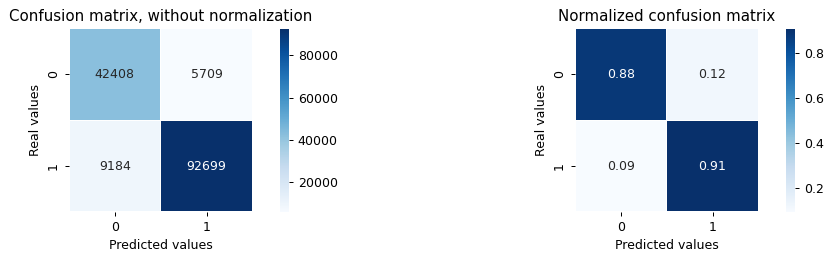

In [95]:
# confusion matrix display:
confusion_matrix_plot(ytest, y_pred_logreg)

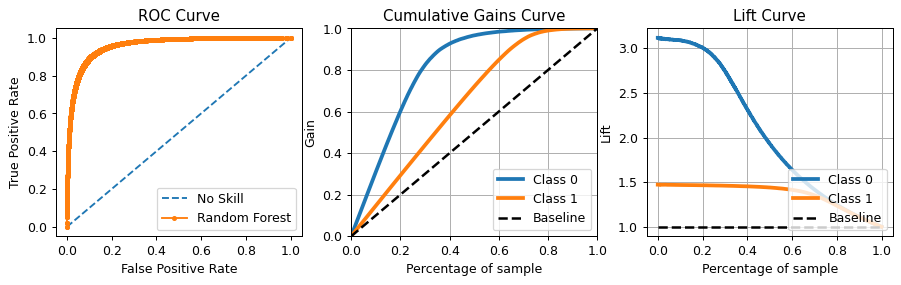

In [96]:
curves(ytest, y_pred_logreg_prob)

#### Roc Curve

Roc curve
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve represents two parameters:True positive rate and False positive rate.

True positive rate (TPR) is synonymous with completeness and is therefore defined as follows: TP/(TP+FN)

False Positive Rate (FPR) is defined as follows: FP/(TN+FP)

An ROC curve represents TPR (sensibilitiy) versus FPR (1-specificity) at different classification thresholds. Therefore, if for a particular threshold of the ROC curve the probability of classifying a value as a positive class is above the ROC curve, we will classify it as a positive class. If it is below, we will classify it as a negative class. As the classification threshold decreases, more items are classified as positive, which increases both false positives and true positives.

AUC stands for "area under the ROC curve". That is, the AUC measures the full two-dimensional area under the full ROC curve (think of an integral calculation) from (0.0) to (1.1). This score gives us a good idea of how well the model works.In this case, AUC score is 0.97, it means that there is a 97% probability that the model can distinguish between positive and negative class.

Reminder: In this line of business, the positive class represents that the user's sentiment according with his review is positive (positive reviews. The negative class represents that the consumer sentiment is negative (negative review).


#### Cumulative Gain Curve

The cumulative gains plot shows the percentage of the total number of cases in a given category "win" by targeting a percentage of the total number of cases.The curve is constructed by ordering all model predictions by their probability of belonging to the positive class, and then calculating the fraction of positive cases at each probability cutoff point. For example, if we take the point on the curve for the "1" class (20%, 30%),you would expect the top 20% to contain approximately the 30% of all cases that actually take that "1" class. Likewise, the top 60% would contain approximately 82% of them. If you select the top 80% , you will get almost all the "1" class values of the data set.

The diagonal line is the "baseline" curve, if you select 10% of the cases from the randomly scored data set, you would expect to "win" approximately 10% of all cases that actually take the "1" category. As we move along the X-axis of the gain curve, its slope becomes less steep because we are adding data to the sample about which we are less certain.

#### Lift Curve

The lift graph is derived from the cumulative gain graph; the Y-axis of the Lift Curve represents the gain of our model with respect to a random model.Thus, the 10% uplift for category "1" is 15% /10% = 1.5.

Knowing this we can learn more about our model and observe that it has an easy time predicting correctly the positive class ("1") for the values it has more "clear", but later suffers a drop and ends up looking like a random model.Therefore,it provides another way to view the information in the cumulative gain graph.

#### Pickle

We are going to save the final model in a pickle format.

In [97]:
# models = [
#     log_reg_cv
# ]

# filenames = [
#     '../models/reviews/final_LR_model.pkl'
# ]

# save_models_to_parquet(models,filenames)

Loading the models from a pickle format.

In [98]:
# filenames = [
#    '../models/reviews/final_LR_model.pkl'
# ]

# log_reg_cv = load_models_from_parquet(filenames)[0]

## Explicability

As we have already analyzed previously how the most common words influence the rating of the reviews, let's make a simpler explanation than in the business line of the restaurants rating.

### SHAP

Global explainability with SHAP values refers to the use of a method called SHAP (SHapley Additive exPlanation) to understand and explain the overall behavior of a machine learning model. SHAP values are a technique for explaining the contribution of each feature, or input variable, to the prediction of a machine learning model. They can be used to explain the overall behavior of a model by understanding how each feature impacts the model's output, as well as to compare the influence of different features on the model's prediction.

In [99]:
# load JS visualization code to notebook
shap.initjs()

In [100]:
vectorizer = log_reg_cv.best_estimator_.named_steps["vectorizer"]
fn = vectorizer.get_feature_names()

In [101]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))
xtrain_preprocessed_vec = vectorizer.fit_transform(xtrain_preprocessed)
xtest_preprocessed_vec = vectorizer.fit_transform(xtest_preprocessed)

In [103]:
explainer = shap.KernelExplainer(log_reg_cv.best_estimator_.named_steps['clf'].predict, xtrain_preprocessed_vec)

In [104]:
shap_values = explainer.shap_values(xtest_preprocessed_vec)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [105]:
colour_test = pd.DataFrame(xtest_preprocessed_vec.todense())

### Global agnostic methods

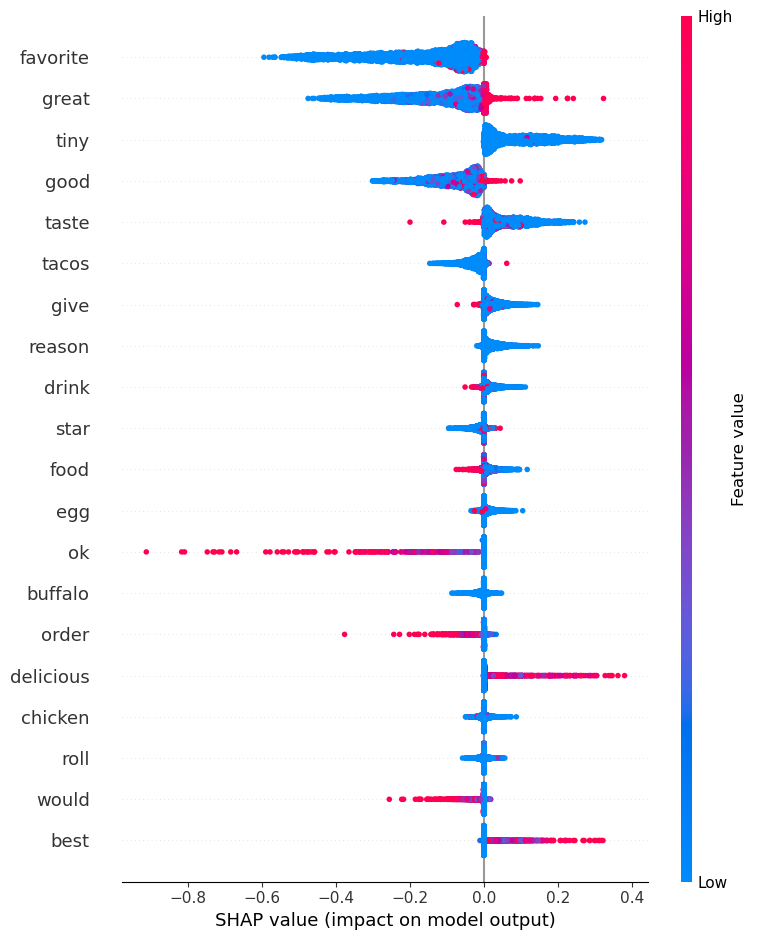

In [106]:
shap.summary_plot(shap_values, colour_test, feature_names=fn)

Analyzing the global explainability of the model, we can observe how the absence of positive words like 'great,' 'favorite,' or the high presence of words like 'delicious' and 'love' tend to classify the reviews as positive. In general, it agrees with the analysis of the most common words carried out previously.

### Local Agnostic Methods

One of the main advantages of SHAP is that it provides a "local" explanation, i.e., it allows us to understand how each feature individually affects the prediction of a model for a specific observation.

The local explainability of SHAP is based on the concept of Shapley value. The Shapley value measures the contribution of each feature to a given prediction, taking into account the interaction between all features. This means that the Shapley value of a given feature for a specific observation depends not only on the feature itself, but also on how it is combined with the other features.

In [122]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[56,:], 
                colour_test.iloc[56,:], feature_names=fn,link='logit')

Here we can see how, at the local level, for this specific observation, the words with their values in the red band (tend to increase the probability of the output) have more weight than the words in the blue band (tend to decrease the probability of the output), classifying this review as positive. This analysis agrees with the previous ones, because in the red band, for example, the words with the most weight are the adjectives 'tiny', 'delicious' and 'excellent' and remember that the output for these observation has a high probability of being a positive review (f(x)=0.73, close to 1).



